In [0]:
!apt-get install tesseract-ocr

In [0]:
!tesseract -v

In [0]:
!sudo add-apt-repository ppa:alex-p/tesseract-ocr



In [0]:
!pip install pillow
!pip install pytesseract
!pip install imutils


In [0]:
!sudo pip install opencv-contrib-python

In [0]:
import cv2, pytesseract,imutils

In [0]:
!tesseract --help-psm


In [0]:
!wget https://github.com/oyyd/frozen_east_text_detection.pb/raw/master/frozen_east_text_detection.pb -P /content/drive/'My Drive'/FormProcessing

In [0]:
'''def decode_predictions(scores, geometry):
	# grab the number of rows and columns from the scores volume, then
	# initialize our set of bounding box rectangles and corresponding
	# confidence scores
	(numRows, numCols) = scores.shape[2:4]
	rects = []
	confidences = []
	# loop over the number of rows
	for y in range(0, numRows):
		# extract the scores (probabilities), followed by the
		# geometrical data used to derive potential bounding box
		# coordinates that surround text
		scoresData = scores[0, 0, y]
		xData0 = geometry[0, 0, y]
		xData1 = geometry[0, 1, y]
		xData2 = geometry[0, 2, y]
		xData3 = geometry[0, 3, y]
		anglesData = geometry[0, 4, y]
		# loop over the number of columns
		for x in range(0, numCols):
			# if our score does not have sufficient probability,
			# ignore it
			if scoresData[x] < 0.5:
				continue
			# compute the offset factor as our resulting feature
			# maps will be 4x smaller than the input image
			(offsetX, offsetY) = (x * 4.0, y * 4.0)
			# extract the rotation angle for the prediction and
			# then compute the sin and cosine
			angle = anglesData[x]
			cos = np.cos(angle)
			sin = np.sin(angle)
			# use the geometry volume to derive the width and height
			# of the bounding box
			h = xData0[x] + xData2[x]
			w = xData1[x] + xData3[x]
			# compute both the starting and ending (x, y)-coordinates
			# for the text prediction bounding box
			endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
			endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
			startX = int(endX - w)
			startY = int(endY - h)
			# add the bounding box coordinates and probability score
			# to our respective lists
			rects.append((startX, startY, endX, endY))
			confidences.append(scoresData[x])
	# return a tuple of the bounding boxes and associated confidences
	return (rects, confidences)'''

In [0]:
from imutils.object_detection import non_max_suppression
import numpy as np
import pytesseract
import time
import cv2

In [0]:
image = cv2.imread("/content/drive/My Drive/test.jpeg")
orig = image.copy()
(origH, origW) = image.shape[:2]
print(image.shape[:2])
newW=320
newH=320
print((newH,newW))
rW = origW / float(newW)
rH = origH / float(newH)
image = cv2.resize(image, (newW, newH))
(H, W) = image.shape[:2]

In [0]:
print("[INFO] loading EAST text detector...")
net = cv2.dnn.readNet("/content/drive/My Drive/FormProcessing/frozen_east_text_detection.pb")

In [0]:
blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
	(123.68, 116.78, 103.94), swapRB=True, crop=False)
start = time.time()
net.setInput(blob)
layerNames = [
	"feature_fusion/Conv_7/Sigmoid",
	"feature_fusion/concat_3"]
(scores, geometry) = net.forward(layerNames)
end = time.time()
# show timing information on text prediction
print("[INFO] text detection took {:.6f} seconds".format(end - start))
# decode the predictions, then  apply non-maxima suppression to
# suppress weak, overlapping bounding boxes
'''(rects, confidences) = decode_predictions(scores, geometry)
boxes = non_max_suppression(np.array(rects), probs=confidences)'''

In [0]:
(numRows, numCols) = scores.shape[2:4]
rects = []
confidences = []
# loop over the number of rows
for y in range(0, numRows):
	# extract the scores (probabilities), followed by the geometrical
	# data used to derive potential bounding box coordinates that
	# surround text
	scoresData = scores[0, 0, y]
	xData0 = geometry[0, 0, y]
	xData1 = geometry[0, 1, y]
	xData2 = geometry[0, 2, y]
	xData3 = geometry[0, 3, y]
	anglesData = geometry[0, 4, y]
	# loop over the number of columns
	for x in range(0, numCols):
		# if our score does not have sufficient probability, ignore it
		if scoresData[x] < 0.5:
			continue
		# compute the offset factor as our resulting feature maps will
		# be 4x smaller than the input image
		(offsetX, offsetY) = (x * 4.0, y * 4.0)
		# extract the rotation angle for the prediction and then
		# compute the sin and cosine
		angle = anglesData[x]
		cos = np.cos(angle)
		sin = np.sin(angle)
		# use the geometry volume to derive the width and height of
		# the bounding box
		h = xData0[x] + xData2[x]
		w = xData1[x] + xData3[x]
		# compute both the starting and ending (x, y)-coordinates for
		# the text prediction bounding box
		endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
		endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
		startX = int(endX - w)
		startY = int(endY - h)
		# add the bounding box coordinates and probability score to
		# our respective lists
		rects.append((startX, startY, endX, endY))
		confidences.append(scoresData[x])

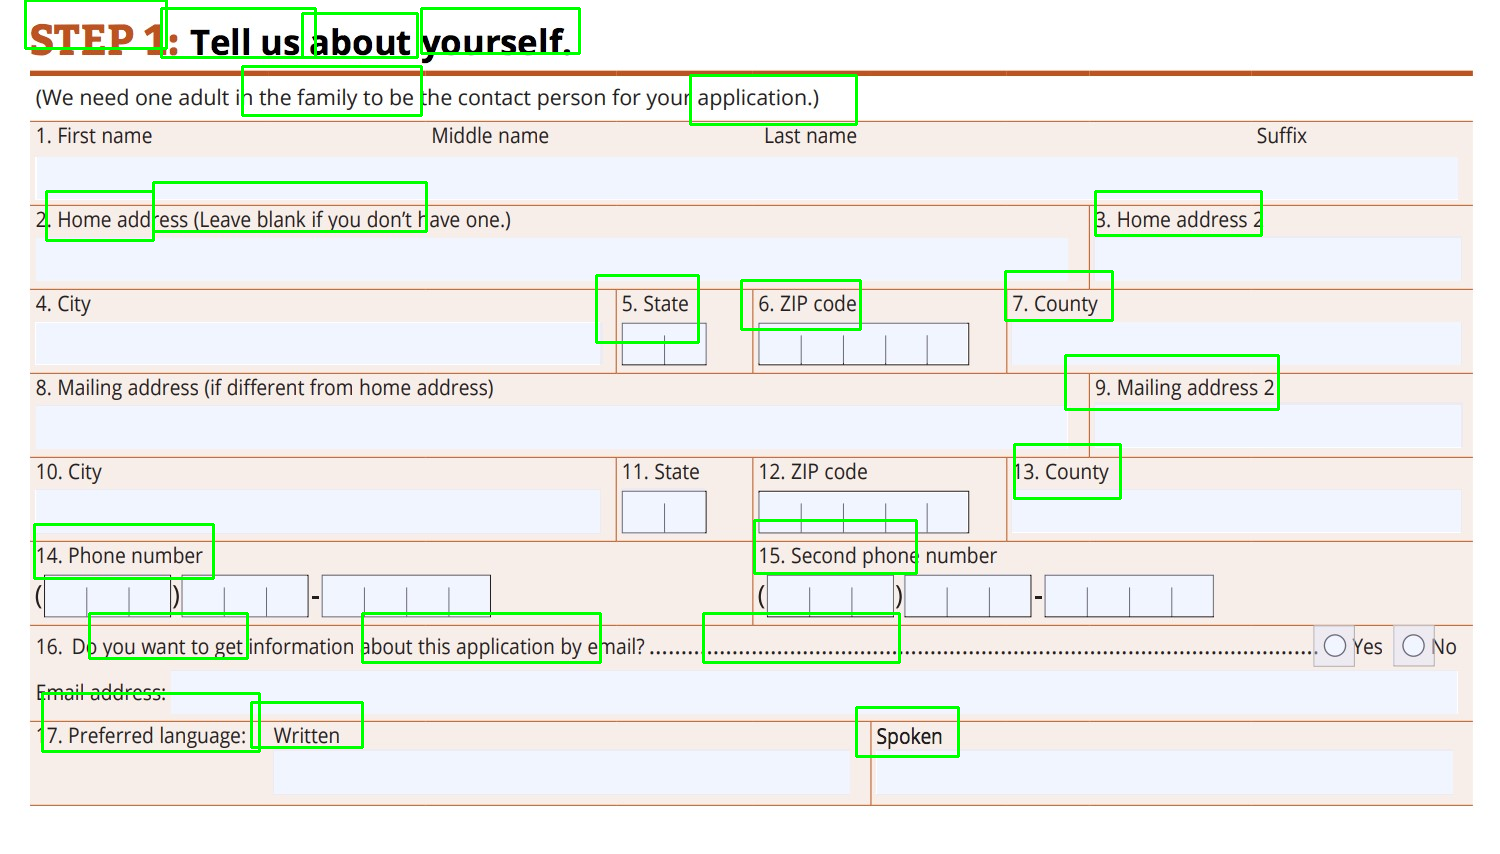

In [0]:
from google.colab.patches import cv2_imshow
# apply non-maxima suppression to suppress weak, overlapping bounding
# boxes
boxes = non_max_suppression(np.array(rects), probs=confidences)
# loop over the bounding boxes
for (startX, startY, endX, endY) in boxes:
	# scale the bounding box coordinates based on the respective
	# ratios
	startX = int(startX * rW)
	startY = int(startY * rH)
	endX = int(endX * rW)
	endY = int(endY * rH)
	# draw the bounding box on the image
	cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)
# show the output image
cv2_imshow(orig)

In [0]:
'''# initialize the list of results
results = []
# loop over the bounding boxes
for (startX, startY, endX, endY) in boxes:
	# scale the bounding box coordinates based on the respective
	# ratios
	startX = int(startX * rW)
	startY = int(startY * rH)
	endX = int(endX * rW)
	endY = int(endY * rH)
	# in order to obtain a better OCR of the text we can potentially
	# apply a bit of padding surrounding the bounding box -- here we
	# are computing the deltas in both the x and y directions
	dX = int((endX - startX) * 0.1)
	dY = int((endY - startY) * 0.1)
	# apply padding to each side of the bounding box, respectively
	startX = max(0, startX - dX)
	startY = max(0, startY - dY)
	endX = min(origW, endX + (dX * 2))
	endY = min(origH, endY + (dY * 2))
	# extract the actual padded ROI
	roi = orig[startY:endY, startX:endX]'''

In [0]:
'''# in order to apply Tesseract v4 to OCR text we must supply
	# (1) a language, (2) an OEM flag of 4, indicating that the we
	# wish to use the LSTM neural net model for OCR, and finally
	# (3) an OEM value, in this case, 7 which implies that we are
	# treating the ROI as a single line of text
	config = ("-l eng --oem 3 --psm 12")
	text = pytesseract.image_to_string(roi, config=config)
	# add the bounding box coordinates and OCR'd text to the list
	# of results
	results.append(((startX, startY, endX, endY), text))'''

OCR TEXT
5. State

|



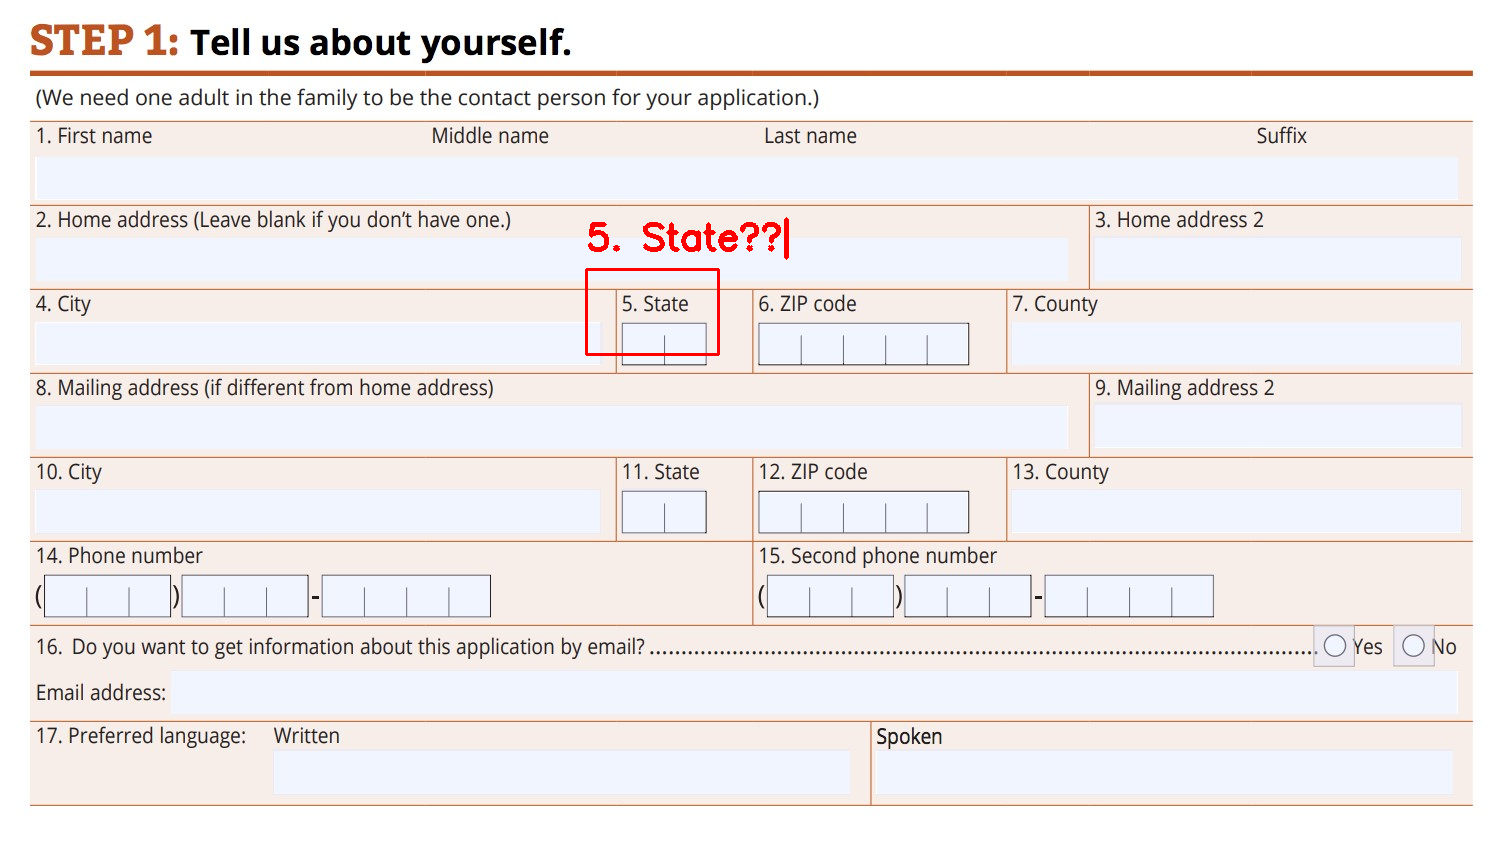

OCR TEXT
5. State

|



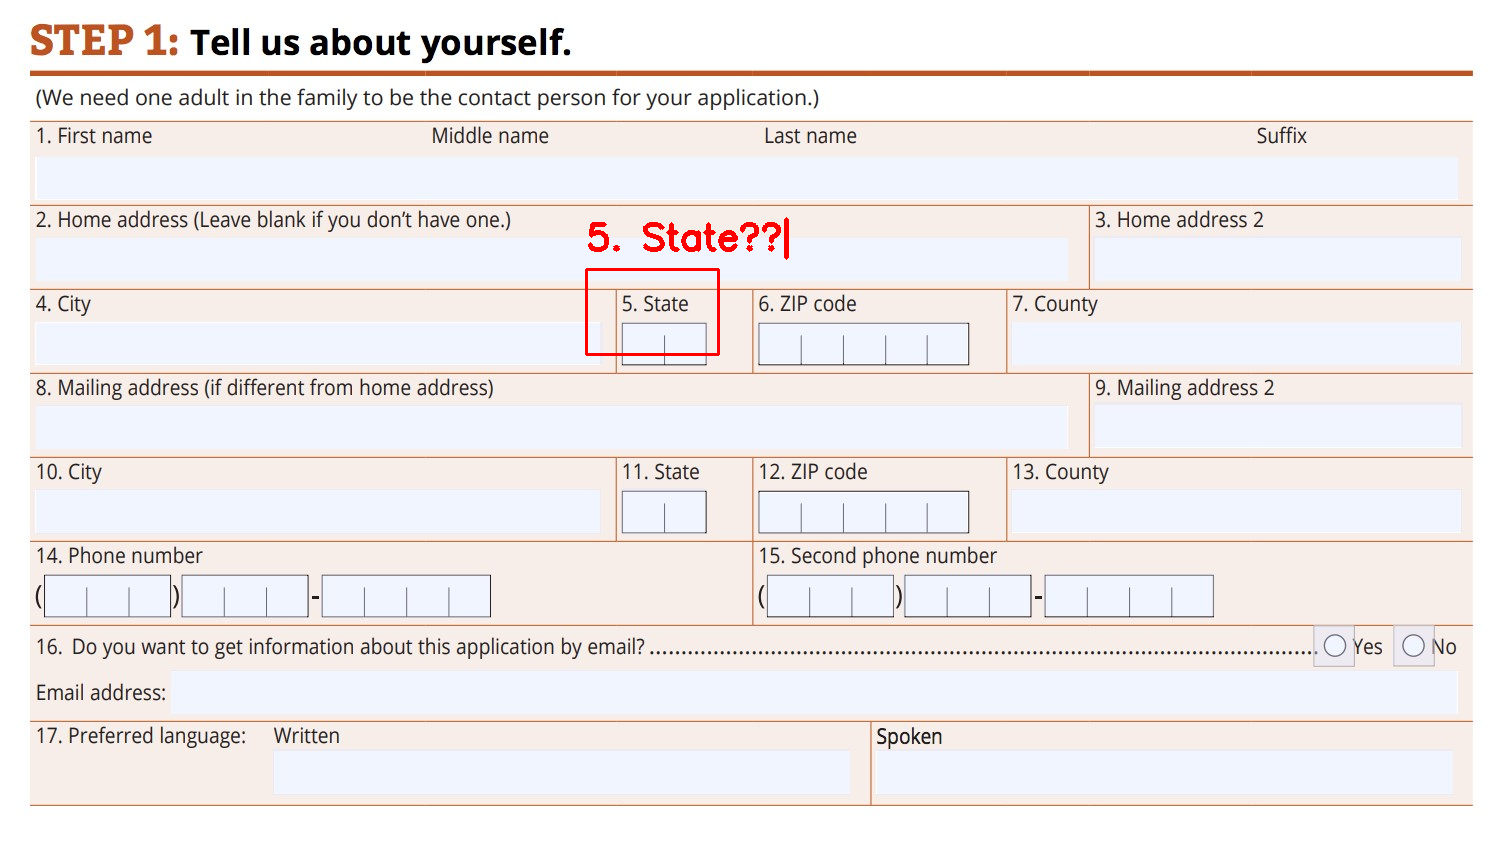

In [0]:
'''from google.colab.patches import cv2_imshow
# sort the results bounding box coordinates from top to bottom
results = sorted(results, key=lambda r:r[0][1])
# loop over the results
for ((startX, startY, endX, endY), text) in results:
	# display the text OCR'd by Tesseract
	print("OCR TEXT")
	print("========")
	print("{}\n".format(text))
	# strip out non-ASCII text so we can draw the text on the image
	# using OpenCV, then draw the text and a bounding box surrounding
	# the text region of the input image
	text = "".join([c if ord(c) < 128 else "" for c in text]).strip()
	output = orig.copy()
	cv2.rectangle(output, (startX, startY), (endX, endY),
		(0, 0, 255), 2)
	cv2.putText(output, text, (startX, startY - 20),
		cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 3)
	# show the output image
	cv2_imshow(output)'''